# Imports

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# Set Pulse

Text(0.5, 1.0, 'Pulses over time')

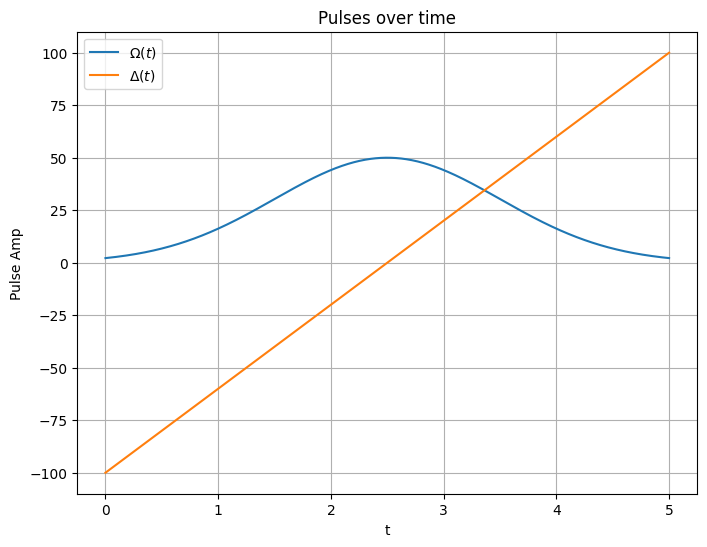

In [24]:
# defining time dependant coefs
T = 5
t = np.linspace(0, T, 1000)
sigma = 1
omega_max = 50
omega_t = omega_max * np.exp(-0.5 * ((t - T/2) / sigma) ** 2)
delta_t = 2*omega_max*(t / (T/2) - 1)

# Plot the wave
plt.figure(figsize=(8, 6))
plt.plot(t, omega_t, label=r'$\Omega(t)$')
plt.plot(t, delta_t, label=r'$\Delta(t)$')
plt.xlabel("t")
plt.ylabel("Pulse Amp")
plt.grid(True)
plt.legend()
plt.title("Pulses over time")


# Defining Stabilizers for 4-qubit code

In [25]:
I = qeye(2)
X = sigmax()
Y = sigmay()
Z = sigmaz()

# Define the stabilizer generators for the 5-qubit bit-flip code
g1 = tensor(X, X, X, X)
g2 = tensor(Z, Z, Z, Z)
g3 = tensor(X, Y, Z, I)

stabilizers = [
    g1,
    g2,
    g3
]

X_L = tensor(Y, I, Y, I)
Z_L = tensor(Z, Z, I, I)
Y_L = -tensor(I, X, X, I)


In [26]:
basis_states = [basis(2, 0), basis(2, 1)]

# Define the logical zero state |0_L>
logical_zero = (tensor(basis_states[0], basis_states[0], basis_states[0], basis_states[0]) +
                1j*tensor(basis_states[0], basis_states[0], basis_states[1], basis_states[1]) +
                1j*tensor(basis_states[1], basis_states[1], basis_states[0], basis_states[0]) +
                tensor(basis_states[1], basis_states[1], basis_states[1], basis_states[1])).unit()

logical_one = X_L * logical_zero

# Applying error
# error = tensor(I, X, I, X)
# logical_zero = error * logical_zero
# logical_one = error * logical_one

# Define projection operators
P0 = logical_zero * logical_zero.dag()
P1 = logical_one * logical_one.dag()
P_tot = P0 + P1

-300 1.0 0.0
-300 0.0 1.0
-100 0.0 0.0
-100 0.0 0.0
-100 0.0 0.0
-100 0.0 0.0
-100 0.0 0.0
-100 0.0 0.0
100 0.0 0.0
100 0.0 0.0
100 0.0 0.0
100 0.0 0.0
100 0.0 0.0
100 0.0 0.0
300 0.0 0.0
300 0.0 0.0
{-300: 2, -100: 6, 100: 6, 300: 2}


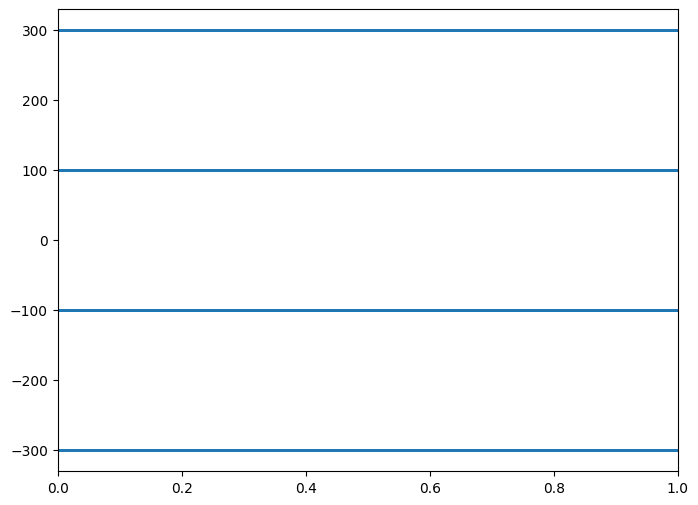

In [27]:
Ep = 100
Hp = -Ep*(g1 + g2 + g3)

eigenvalues, eigenstates = Hp.eigenstates()

energies = {}
colors = [
    'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan',
    'magenta', 'yellow', 'lime', 'teal', 'gold', 'navy'
]

plt.figure(figsize=(8, 6))

# Loop through both arrays
for energy, state in zip(eigenvalues, eigenstates):
    energy = int(np.round(energy, 1))
    
    if energy not in energies.keys():
        energies[energy] = 1
    else:
        energies[energy] += 1    
    plt.axhline(y = energy, linestyle = '-', linewidth = 2)
    
    proj_zero = np.abs(logical_zero.overlap(state))**2
    proj_one = np.abs(logical_one.overlap(state))**2

    print(energy, np.round(proj_zero), np.round(proj_one))
print(energies)

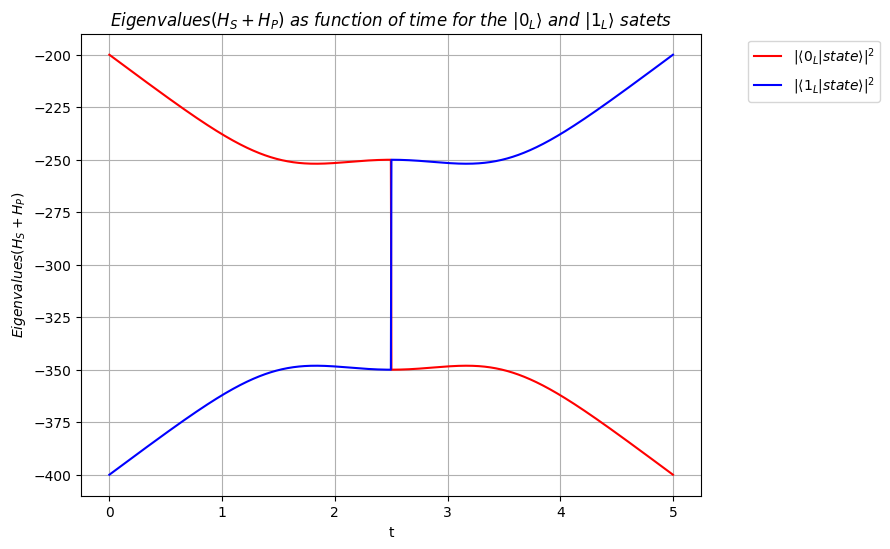

In [28]:
one_eigens = []
zero_eigens = []

for i, t_step in enumerate(t):
    H_S = omega_t[i] * X_L + delta_t[i] * Z_L + Hp
    eigenvalues, eigenstates = H_S.eigenstates()
    
    for energy, state in zip(eigenvalues, eigenstates):        
        proj_zero = np.round(np.abs(logical_zero.overlap(state))**2)
        proj_one = np.round(np.abs(logical_one.overlap(state))**2)
        if proj_zero:
            zero_eigens.append(energy)
        if proj_one:
            one_eigens.append(energy)

plt.figure(figsize=(8, 6))
plt.plot(t, one_eigens, color='r', label =r'$| \langle 0_{L} | state \rangle | ^{2}$')
plt.plot(t, zero_eigens, color='b', label =r'$| \langle 1_{L} | state \rangle | ^{2}$')
plt.xlabel('t')
plt.ylabel(r'$Eigenvalues(H_{S} + H_{P})$')
plt.title(r'$Eigenvalues(H_{S} + H_{P}) \ as \ function \ of \ time \ for \ the \ |0_{L} \rangle \ and \ |1_{L} \rangle \ satets$')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.grid(True)

# Ploting the full energy diagram

In [29]:
Ep = 150
Hp = -Ep*(g1 + g2 + g3)

T = 10
t = np.linspace(0, T, 1000)
sigma = 1
omega_max = 50
omega_t = omega_max * np.exp(-0.5 * ((t - T/2) / sigma) ** 2)
delta_t = 2*omega_max*(t / (T/2) - 1)

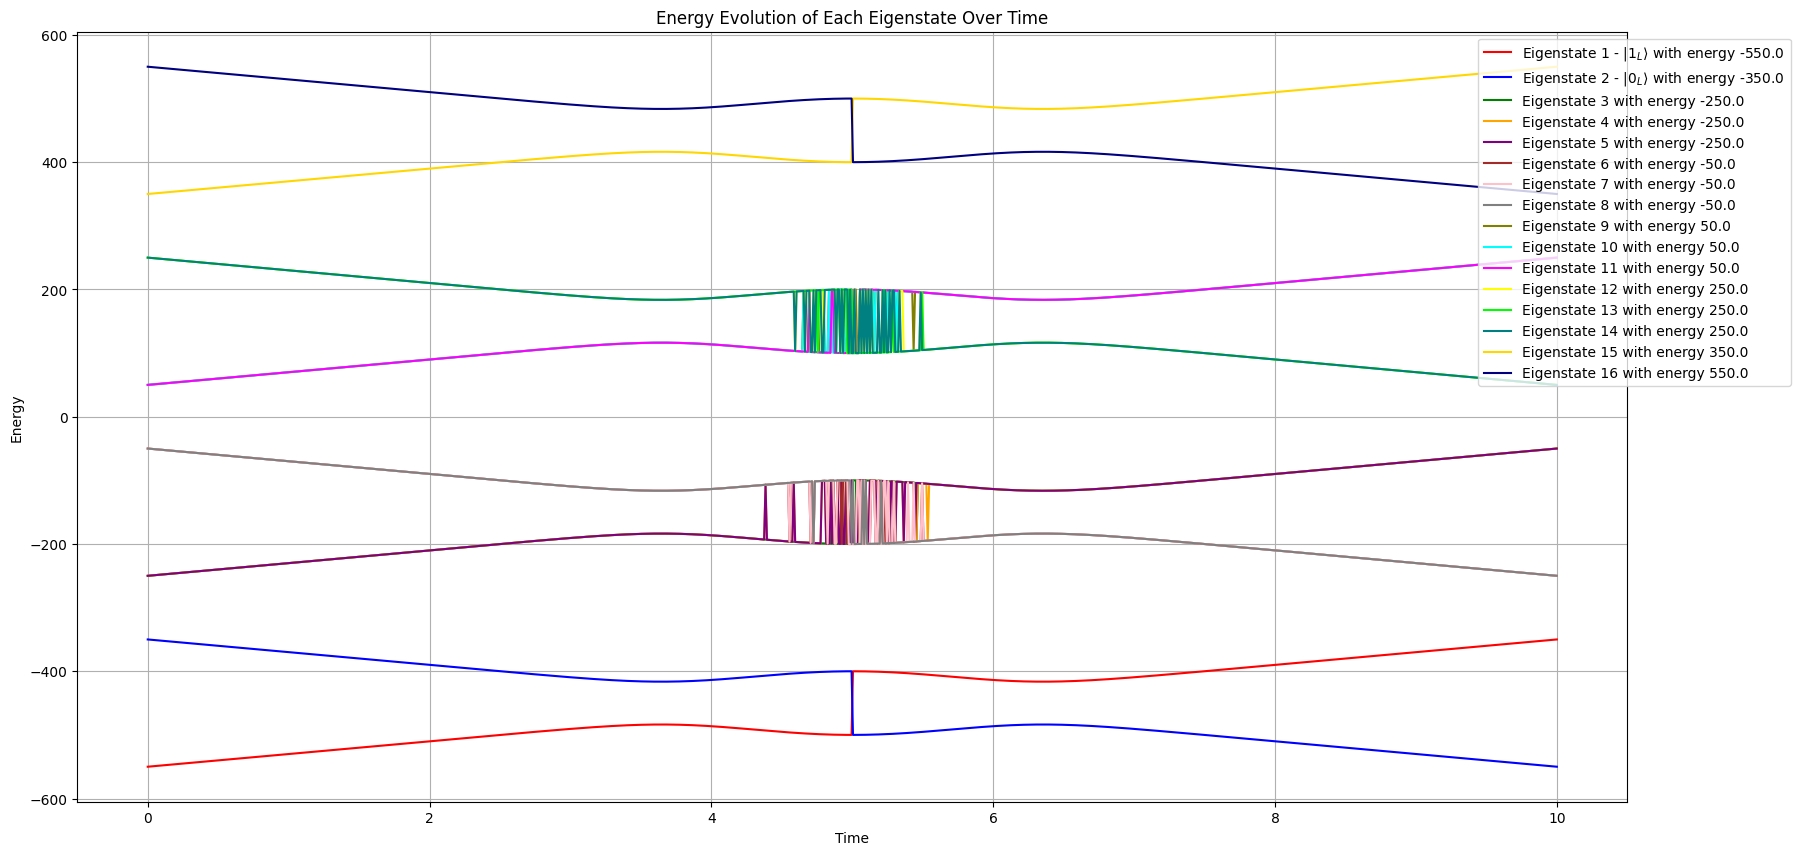

In [30]:
colors = [
    'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan',
    'magenta', 'yellow', 'lime', 'teal', 'gold', 'navy'
]

H_S_0 = omega_t[0] * X_L + delta_t[0] * Z_L + Hp
eigenvalues_0, eigenstates_0 = H_S_0.eigenstates()

states = {index: [energy] for index, energy in enumerate(eigenvalues_0)}

for t_step in range(1, len(t)):
    H_S = omega_t[t_step] * X_L + delta_t[t_step] * Z_L + Hp
    eigenvalues, eigenstates = H_S.eigenstates()

    for state_index, state_0 in enumerate(eigenstates_0):
        max_overlap = 0
        best_match_index = 0
        
        for i, state_t in enumerate(eigenstates):
            proj = np.abs(state_0.overlap(state_t))**2
            if proj > max_overlap:
                max_overlap = proj
                best_match_index = i

        states[state_index].append(eigenvalues[best_match_index])


plt.figure(figsize=(20, 10))
for state_index, energies in states.items():
    
    # if state_index == 9 - 1:
    #     plt.plot(t, energies, label=f'Eigenstate {state_index+1}', color=colors[state_index % len(colors)])
    # 
    #     print([int(np.round(i)) for i in energies])
    
    if np.round(np.abs(eigenstates[state_index].overlap(logical_zero))**2) == 1:
        plt.plot(t, energies, label=f'Eigenstate {state_index+1} - ' + r'$|0_{L}\rangle$' + " with energy " + str(np.round(eigenvalues_0[state_index])), color=colors[state_index % len(colors)])
    elif np.round(np.abs(eigenstates[state_index].overlap(logical_one))**2) == 1:
        plt.plot(t, energies, label=f'Eigenstate {state_index+1} - ' + r'$|1_{L}\rangle$' + " with energy " + str(np.round(eigenvalues_0[state_index])), color=colors[state_index % len(colors)])
    else:
        plt.plot(t, energies, label=f'Eigenstate {state_index+1}' + " with energy " + str(np.round(eigenvalues_0[state_index])), color=colors[state_index % len(colors)])
    

plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('Energy Evolution of Each Eigenstate Over Time')
plt.legend(loc='upper right', bbox_to_anchor=(1.11, 1))
plt.grid()
plt.show()

Solving the master equation for an open system
$$
\frac{d\rho}{dt} = -i[H_{S}, \rho] - \sum_{a,b} M_{ab}\mathcal{E}_{ab}
$$

Where 

$$
H_{S} = H_{SL} + H_{SP}
$$

- $ H_{SL} $ is the Logic Hamiltonian for the adiabatic calculation.
- $ H_{SP} $ is the sum of penalty terms.

$$ 
$H_{SL}(t) = \Omega(t)X_{L}^{\otimes n} + \Delta(t)Z_{L}^{\otimes n}$
$$
$$ 
H_{SP}(t) = -E_{P} \sum_{k} g_k
$$

and 

$$
M_{ab} = \sum_i \left[N_{ba}|g_{ba}|^2 \langle a|\sigma^{(i)}_{-} |b\rangle \langle b| \sigma^{(i)}_{+} |a\rangle + (N_{ab} + 1)|g_{ab}|^2 \langle b|\sigma^{(i)}_{-} |a\rangle h_a \sigma^{(i)}_{+} |b\rangle \right]
$$
$$
\mathcal{E}_{ab}(\rho) = |a\rangle \langle a| \rho + \rho |a\rangle \langle a| - 2 |b\rangle \langle a| \rho |a\rangle \langle b|
$$

This is just a const and we assume $N_{ba} = \frac{1}{\exp[\beta(\omega_b - \omega_a)] - 1} = 0$ , so we claim $M_{ab} = \sqrt{\gamma_{n}}$

If we denote $|b\rangle \langle a| = A_{n}$ so $|a\rangle \langle b| = A_{n}^{\dagger}$, and lets denote $C_n = \sqrt{\gamma_n} A_{n}$ are the collapse operators.

the first equation $\frac{d\rho}{dt} = -i[H_{S}, \rho] - \sum_{a,b} M_{ab}\mathcal{E}_{ab}$ gets the form 

$$
\frac{d\rho}{dt} = -i[H_{S}, \rho] - \sum_{a,b} M_{ab}\mathcal{E}_{ab} = -i[H_{S}, \rho] + \sum_{n} \frac{1}{2}[2C_{n}\rho(t) C_{n}^{\dagger} - \rho(t)C_{n}^{\dagger} C_{n} - C_{n}^{\dagger} C_{n}\rho(t)]
$$

Here I'm trying to calculate 

$$
M_{0b} = \sum_{i} N_{b0} |g_{b0}|^2 \langle 0 | \sigma^{(i)}_{-} | b \rangle \langle b | \sigma^{(i)}_{+} | 0 \rangle.
$$

without considering the $N_{b0} |g_{b0}|^2$ parts. $|b \rangle \in C^{\perp}$ so I am assuming $|b\rangle = |1_{L}\rangle$

There is an odd behavior for $Ep=100$

In [45]:
def bed(wb0):
    beta = 1e-18
    return 1/(np.exp(beta*(wb0)) - 1)

# def gab() 

T = 10
t = np.linspace(0, T, 1000)
sigma = 1
omega_max = 50
omega_t = omega_max * np.exp(-0.5 * ((t - T/2) / sigma) ** 2)
delta_t = 100*(t / (T/2) - 1)

Eps = np.linspace(1, 200, 200)

gamma_sqrt = 1


gammas = []


for Ep in Eps:   
    Hp = -Ep*(g1 + g2 + g3)
    H_S_0 = omega_t[0] * X_L + delta_t[0] * Z_L + Hp
    eigenvalues_0, eigenstates_0 = H_S_0.eigenstates()
    
    C_op = gamma_sqrt * sigmam()
    sigmams = [
        tensor(C_op, I, I, I),
        tensor(I, C_op, I, I),
        tensor(I, I, C_op, I),
        tensor(I, I, I, C_op)
    ]
    
    Cp_ops = gamma_sqrt * sigmap()
    sigmaps = [
        tensor(Cp_ops, I, I, I),
        tensor(I, Cp_ops, I, I),
        tensor(I, I, Cp_ops, I),
        tensor(I, I, I, Cp_ops)
    ]
    
    for i, state in enumerate(eigenstates_0):
        
        if i == 4:
            # omega_b0 = expect(H_S_0, state) - expect(H_S_0, logical_zero)
        # if np.round(np.abs(state.overlap(logical_one))**2) == 1:
        #     print(Ep, str(i) + r" - |1L>", omega_b0)
            Mab = 0
            for index, op in enumerate(sigmams):
                Mab += logical_zero.dag() * op * state * state.dag() * sigmaps[index] * logical_zero
            gammas.append(np.abs(Mab))
            
            # print(Ep, np.abs(Mab))            
plt.figure(figsize=(8,6))
plt.plot(Eps, gammas)

plt.xlabel(r'$E_{p}$')
plt.ylabel(r'$M_{0b}$')
plt.title(r'$M_{0b}$' + ' as function of ' + r'$E_{p}$')
plt.grid()
plt.show()

TypeError: operand 'Qobj' does not support ufuncs (__array_ufunc__=None)

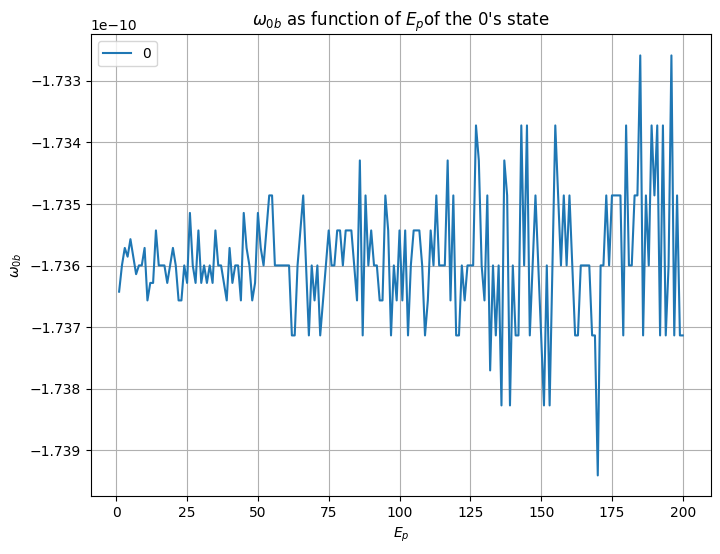

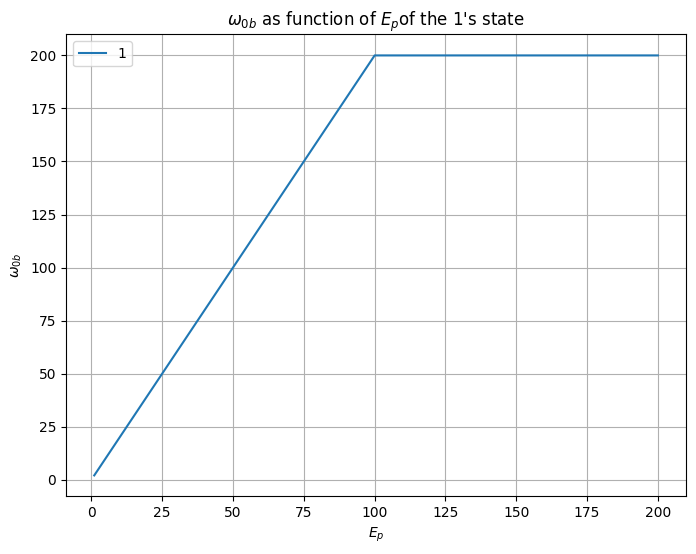

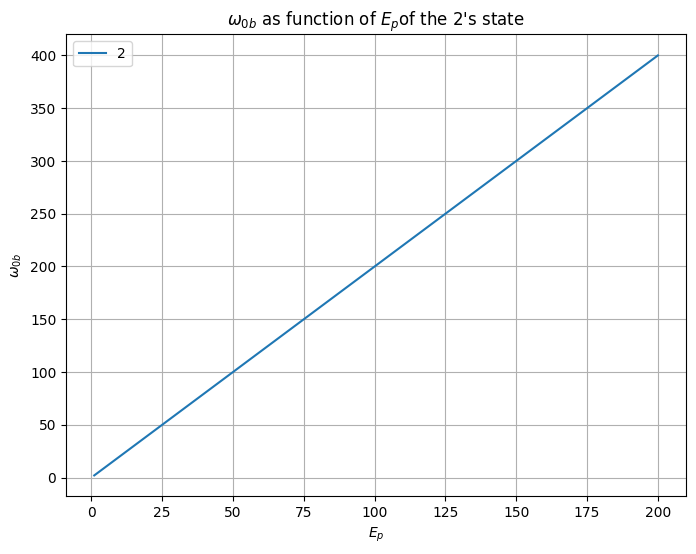

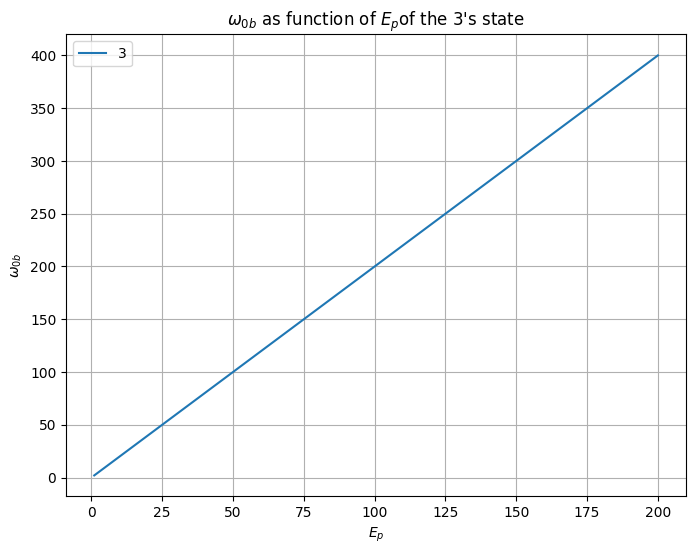

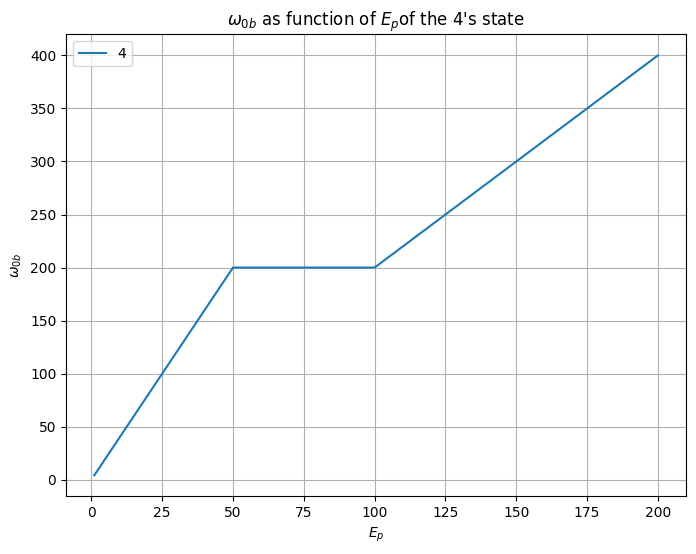

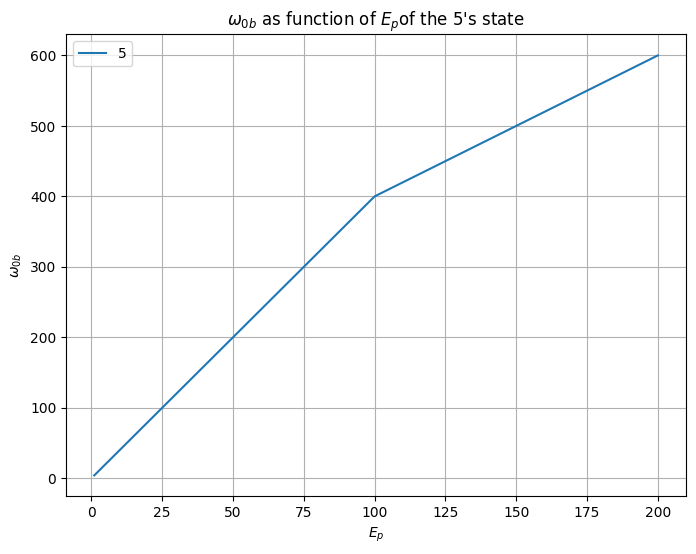

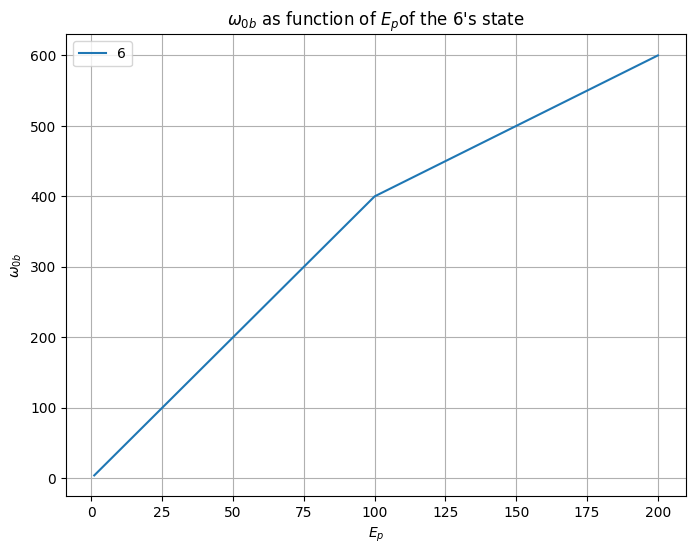

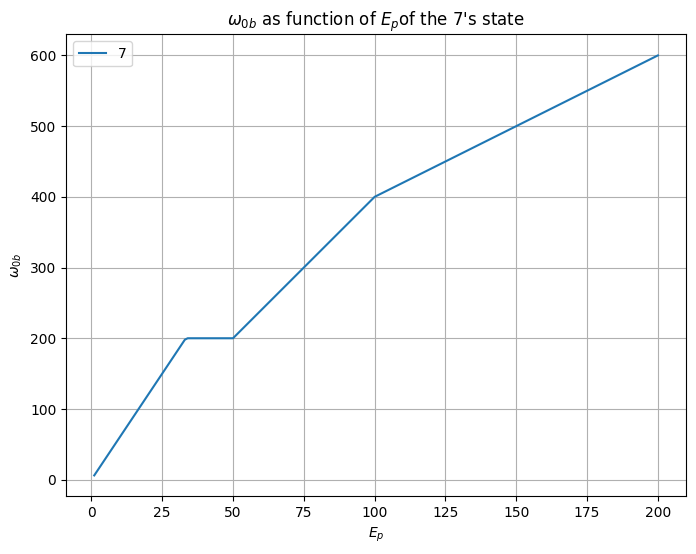

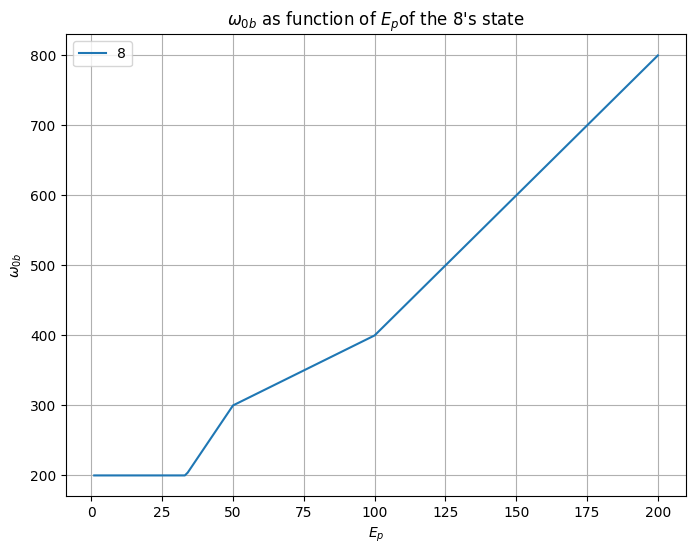

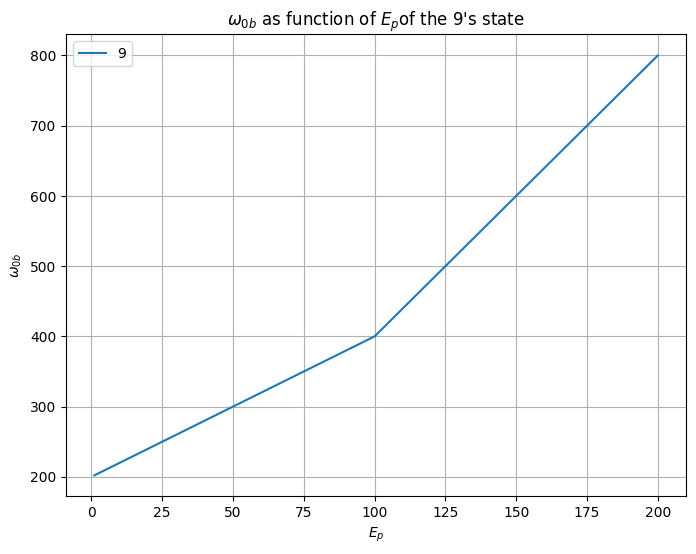

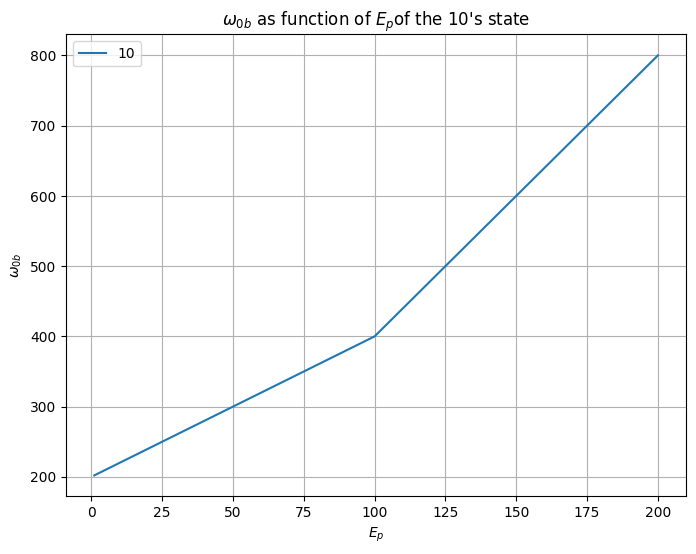

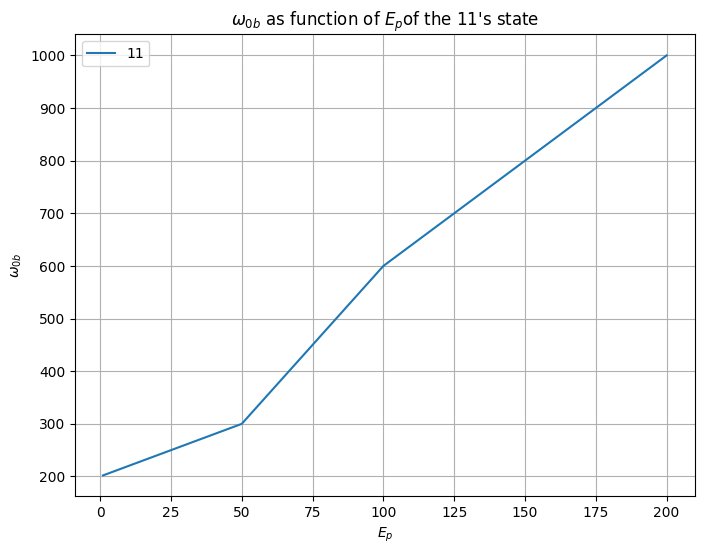

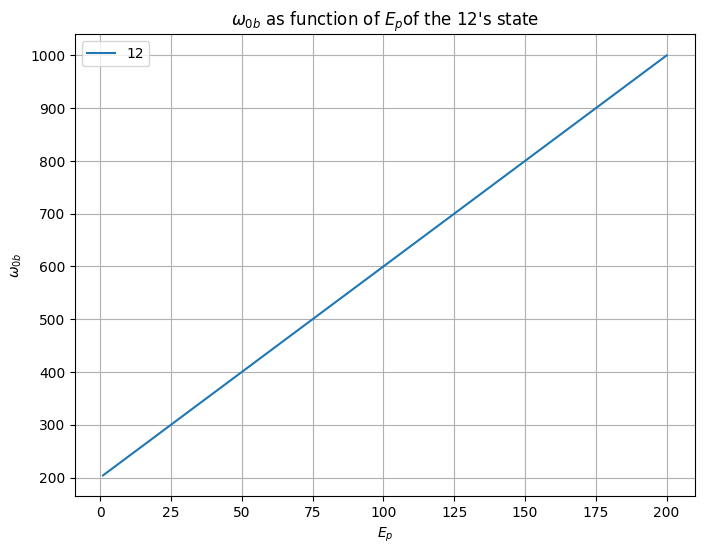

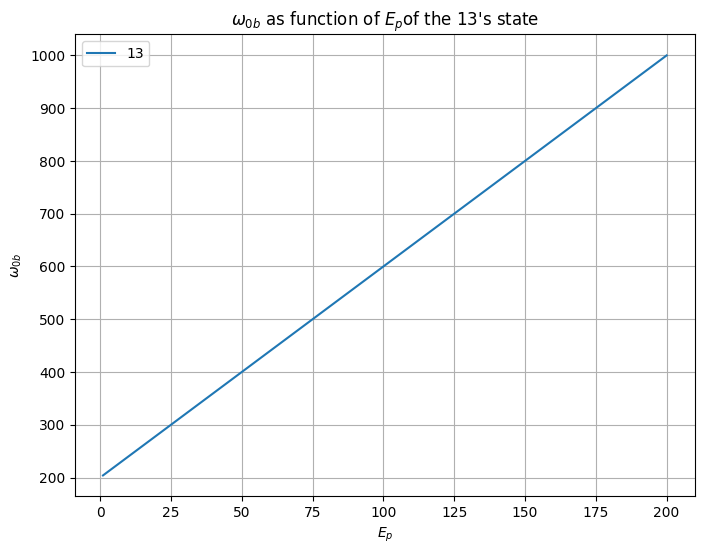

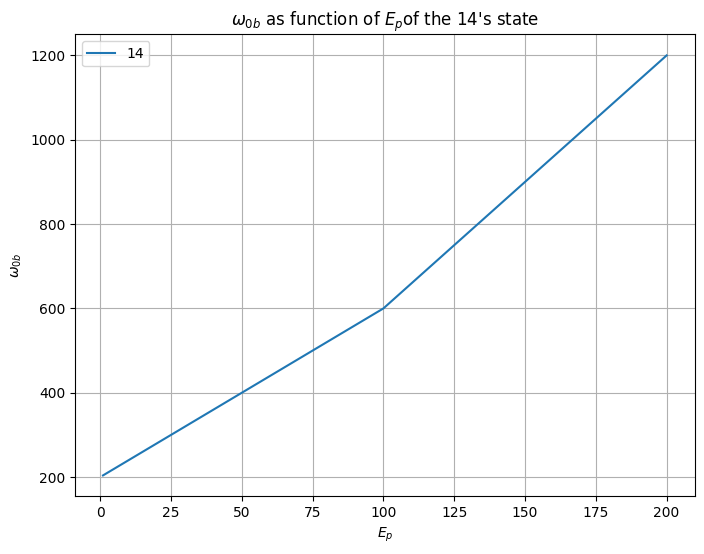

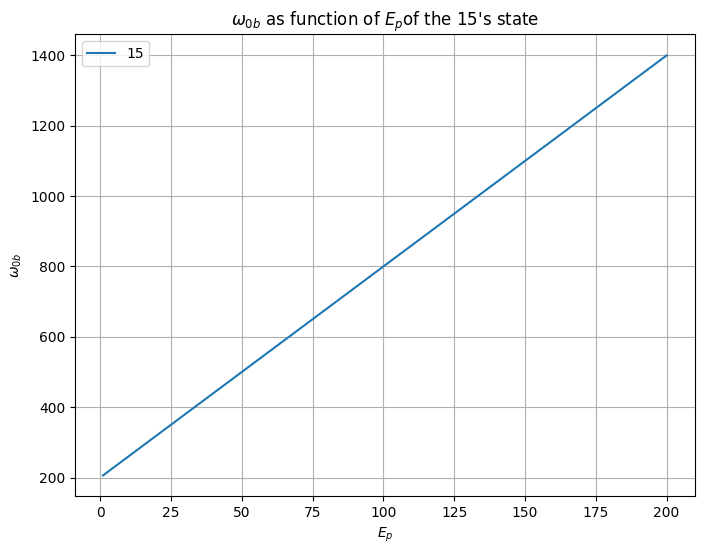

In [61]:
T = 10
t = np.linspace(0, T, 1000)
sigma = 1
omega_max = 50
omega_t = omega_max * np.exp(-0.5 * ((t - T/2) / sigma) ** 2)
delta_t = 100*(t / (T/2) - 1)

Eps = np.linspace(1, 200, 200)


for state_index in range(16):
# state_index = 4
    plt.figure(figsize=(8,6))

    omegas = []

    for Ep in Eps:   
        Hp = -Ep*(g1 + g2 + g3)
        H_S_0 = omega_t[0] * X_L + delta_t[0] * Z_L + Hp
        eigenvalues_0, eigenstates_0 = H_S_0.eigenstates()
        
        for i, state in enumerate(eigenstates_0):
            if i == state_index:
                omega_b0 = expect(H_S_0, state) - expect(H_S_0, logical_zero)    
                omegas.append(omega_b0)
                
    plt.plot(Eps, omegas, label=str(state_index))

    plt.xlabel(r'$E_{p}$')
    plt.ylabel(r'$\omega_{0b}$')
    plt.title(r'$\omega_{0b}$' + ' as function of ' + r'$E_{p}$' + f'of the {state_index}\'s state')
    plt.grid()
    plt.legend()
    plt.show()

1.5585361279739827e-35
0 8


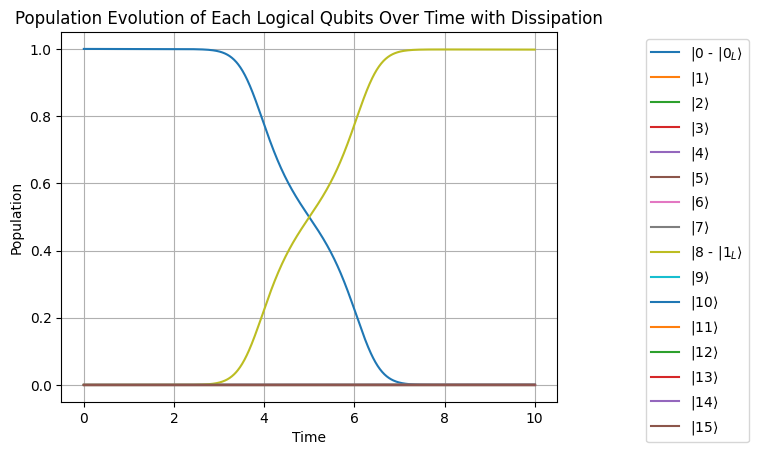

In [743]:
Ep = 100
Hp = -Ep*(g1 + g2 + g3)

T = 10
t = np.linspace(0, T, 1000)
sigma = 1
omega_max = 50
omega_t = omega_max * np.exp(-0.5 * ((t - T/2) / sigma) ** 2)
delta_t = 2*omega_max*(t / (T/2) - 1)

gamma_sqrt = 0.01

H_S_0 = omega_t[0] * X_L + delta_t[0] * Z_L + Hp
eigenvalues_0, eigenstates_0 = H_S_0.eigenstates()

C_op = gamma_sqrt * sigmam()

# Collapse operators for the open system
collapse_ops = [
    tensor(C_op, I, I, I),
    tensor(I, C_op, I, I),
    tensor(I, I, C_op, I),
    tensor(I, I, I, C_op)
]

Cp_ops = gamma_sqrt * sigmap()
sigmaps = [
    tensor(Cp_ops, I, I, I),
    tensor(I, Cp_ops, I, I),
    tensor(I, I, Cp_ops, I),
    tensor(I, I, I, Cp_ops)
]

# collapse_ops = [
#     gamma_sqrt * logical_one*logical_zero.dag()
# ]

e_ops = []
# collapse_ops = []

zero_index = None
one_index = None
for i, state in enumerate(eigenstates_0):
    e_ops.append(state*state.dag())
    
    if np.round(np.abs(state.overlap(logical_zero))**2) == 1:
        zero_index = i
    elif np.round(np.abs(state.overlap(logical_one))**2) == 1:
        Mab = 0
        for index, op in enumerate(collapse_ops):
            Mab += logical_zero.dag() * op * state * state.dag() * sigmaps[index] * logical_zero
        print(np.abs(Mab))    
        one_index = i
    #     collapse_ops.append(gamma_sqrt*state*logical_zero.dag())
    # else:
    #     collapse_ops.append(gamma_sqrt*state*logical_zero.dag())
        
print(zero_index, one_index)

H_S = [[X_L, omega_t], [Z_L, delta_t], Hp]

result = mesolve(H_S, logical_zero, t, c_ops=collapse_ops, e_ops=e_ops)

for i in range(len(e_ops)):
    pop_i = result.expect[i]
    
    if i == one_index:
        plt.plot(t, pop_i, label=f"|{i} - " + r'$|1_{L}\rangle$')
    elif i == zero_index:
        plt.plot(t, pop_i, label=f"|{i} - " + r'$|0_{L}\rangle$')
    else:
        plt.plot(t, pop_i, label=f"|{i}" + r"$\rangle$")
        
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Population Evolution of Each Logical Qubits Over Time with Dissipation')
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1))
plt.grid()
plt.show()

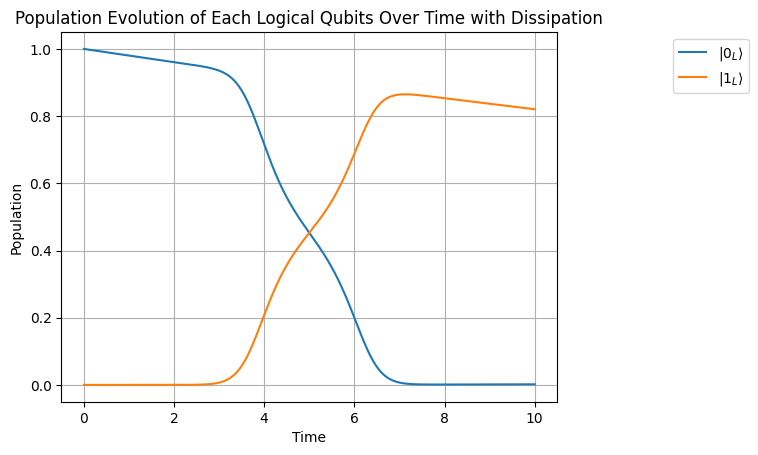

In [682]:
Ep = 200
Hp = -Ep*(g1 + g2 + g3)

T = 10
t = np.linspace(0, T, 1000)
sigma = 1
omega_max = 50
omega_t = omega_max * np.exp(-0.5 * ((t - T/2) / sigma) ** 2)
delta_t = 2*omega_max*(t / (T/2) - 1)

gamma_sqrt = 0.1
C_op = gamma_sqrt * sigmam()

collapse_ops = [
    tensor(C_op, I, I, I),
    tensor(I, C_op, I, I),
    tensor(I, I, C_op, I),
    tensor(I, I, I, C_op)
]

H_S = [[X_L, omega_t], [Z_L, delta_t], Hp]

P0 = logical_zero*logical_zero.dag()
P1 = logical_one*logical_one.dag()

result = mesolve(H_S, logical_zero, t, c_ops=collapse_ops, e_ops=[P0, P1])

pop_0 = result.expect[0]
pop_1 = result.expect[1]

plt.plot(t, pop_0, label=r'$|0_{L}\rangle$')
plt.plot(t, pop_1, label=r'$|1_{L}\rangle$')

plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Population Evolution of Each Logical Qubits Over Time with Dissipation')
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1))
plt.grid()
plt.show()

# Trying to solve differently

In [703]:
Ep = 100
Hp = -Ep*(g1 + g2 + g3)

T = 10
t = np.linspace(0, T, 1000)
sigma = 1
omega_max = 50
omega_t = omega_max * np.exp(-0.5 * ((t - T/2) / sigma) ** 2)
delta_t = 2*omega_max*(t / (T/2) - 1)

gamma_sqrt = 0.01

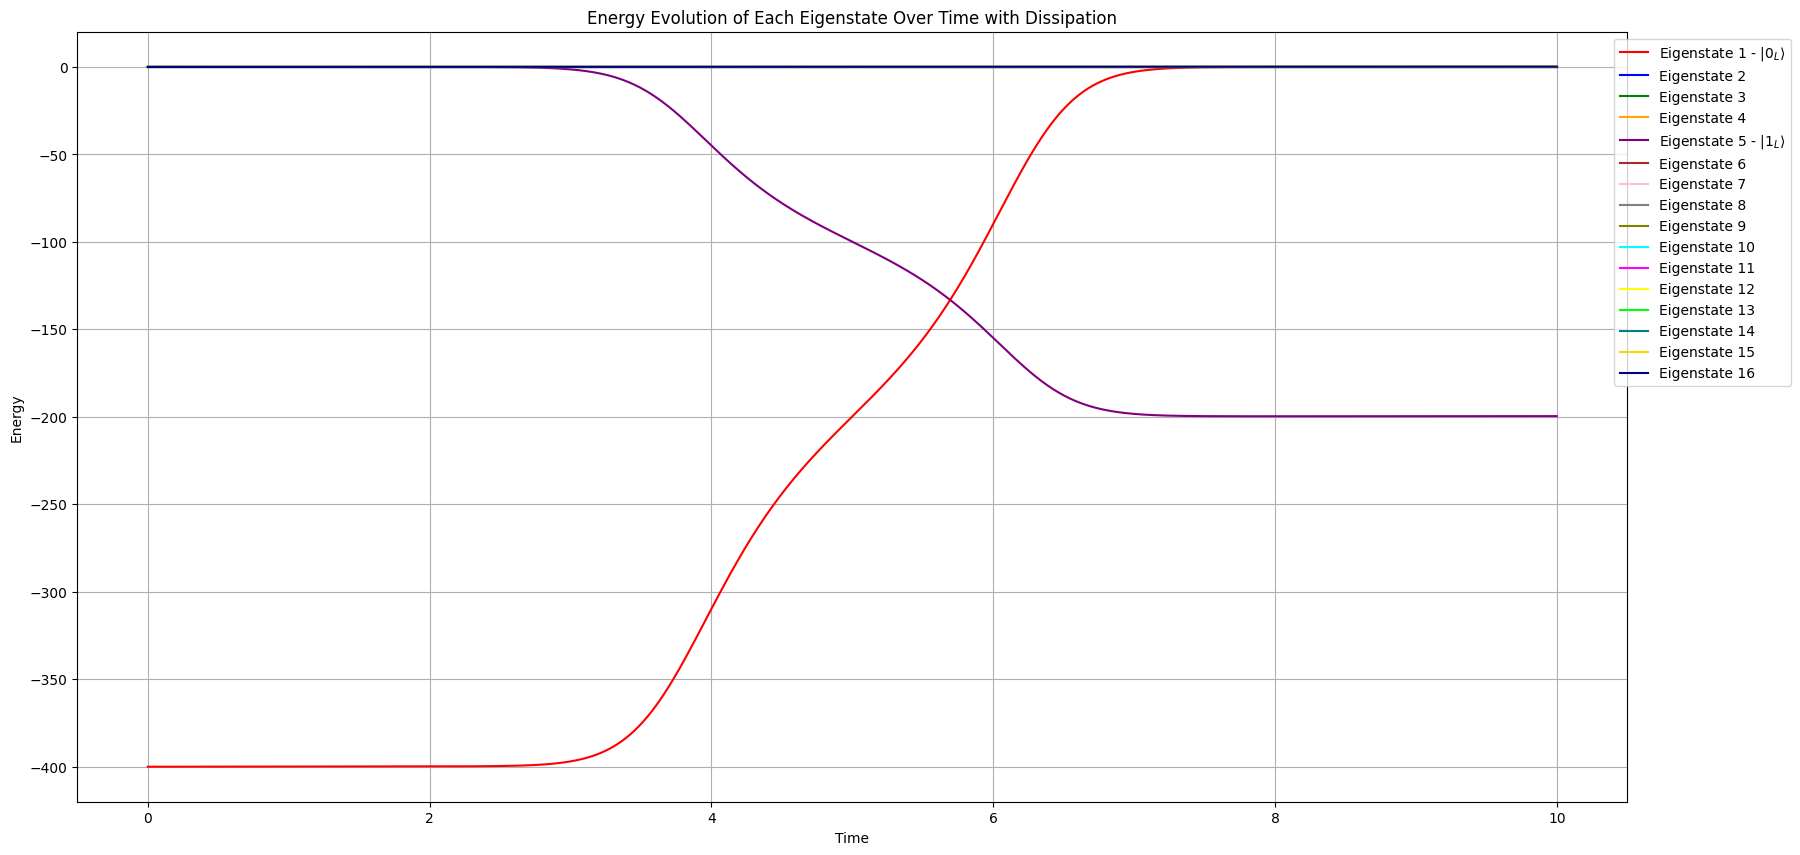

In [704]:
C_op = gamma_sqrt * sigmam()

# Collapse operators for the open system
collapse_ops = [
    tensor(C_op, I, I, I),
    tensor(I, C_op, I, I),
    tensor(I, I, C_op, I),
    tensor(I, I, I, C_op)
]

H_S_0 = omega_t[0] * X_L + delta_t[0] * Z_L + Hp
eigenvalues_0, eigenstates_0 = H_S_0.eigenstates()
energy_evolution_open_system = {index: [] for index in range(len(eigenvalues_0))}

H_S = [[X_L, omega_t], [Z_L, delta_t], Hp]
result = mesolve(H_S, logical_zero, t, collapse_ops, [])

for i, evolved_state in enumerate(result.states):
    for index, eigenstate in enumerate(eigenstates_0):
        energy = expect(eigenstate.proj(), evolved_state) * eigenvalues_0[index]
        energy_evolution_open_system[index].append(np.real(energy))

plt.figure(figsize=(20, 10))
for state_index, energies in energy_evolution_open_system.items():
    if np.round(np.abs(eigenstates_0[state_index].overlap(logical_zero))**2) == 1:
        plt.plot(t, energies, label=f'Eigenstate {state_index+1} - ' + r'$|0_{L}\rangle$', color=colors[state_index % len(colors)])
    elif np.round(np.abs(eigenstates_0[state_index].overlap(logical_one))**2) == 1:
        plt.plot(t, energies, label=f'Eigenstate {state_index+1} - ' + r'$|1_{L}\rangle$', color=colors[state_index % len(colors)])
    else:
        plt.plot(t, energies, label=f'Eigenstate {state_index+1}', color=colors[state_index % len(colors)])

plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('Energy Evolution of Each Eigenstate Over Time with Dissipation')
plt.legend(loc='upper right', bbox_to_anchor=(1.11, 1))
plt.grid()
plt.show()
